In [14]:
# | output: false
# Setup Notebook

path = "../../../../scripts/notebook_header.py"
import os


if os.path.basename(os.getcwd()) != "mtg-modeling":
    args = f"--path {path}"
    get_ipython().run_line_magic("run", f"-i {path} {args}")  # type: ignore

In [31]:
import polars as pl
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns



import src.plots.annotate as anno

import src.plots.symbols as symbols

In [16]:
set_code = "All_Sets"
set_codes_order = ["MKM", "OTJ", "MH3", "BLB"]

paths = {
    "processed": Path("data/processed/17lands/game_data/premier_draft"),
}
summary_file = paths["processed"] / f"{set_code}_Game_PD_Summary.parquet"
game_file = paths["processed"] / f"{set_code}_Game_PD_Games.parquet"
draft_file = paths["processed"] / f"{set_code}_Game_PD_Drafts.parquet"
card_file = paths["processed"] / f"{set_code}_Game_PD_Cards.parquet"

In [17]:
df_draft = pl.scan_parquet(draft_file)
df_summary = pl.scan_parquet(summary_file)

# Player Rank

To assess player skill, I plotted the number of wins by player rank. While I don’t have player IDs to track individual performance, this view provides an average performance snapshot of the player base. Additionally, since I cannot track the number of drafts per player, more frequent players will be over-represented in the data.

Although opponent rankings are not available, we can infer that most opponents are of similar rank due to Arena’s draft system, which matches players with similar records. Each ranked season lasts about a month, and ranks experience "rank decay" between seasons. This decay means that at the start of a new season, a player's rank is lower, requiring them to play more games to regain their previous standing.

Therefore, our snapshot of each rank includes a mix of lower-skill players who have reached their peak at the end of the season and higher-skill players at the start of the season who are climbing back up the ranks.

In @fig-rank-games we see that most drafts are played by players in the Platinum ranks.

In [18]:
draft_rank = (
    df_draft.group_by("rank")
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)

ordered_ranks = {
    0: "bronze",
    1: "silver",
    2: "gold",
    3: "platinum",
    4: "diamond",
    5: "mythic",
}

ordered_ranks_df = pl.LazyFrame(
    {"rank_value": list(ordered_ranks.keys()), "rank": list(ordered_ranks.values())}
).with_columns(
    # Create the rank_name column
    (pl.col("rank_value").cast(str) + " " + pl.col("rank").str.to_uppercase()).alias(
        "rank_name"
    )
)

ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

ranks["win_rate"] = ranks["n_wins"] / ranks["n_games"]

In [19]:
mean_win_rate = df_summary.collect().to_pandas()["win_rate"].values[0]
# print(f"Average Win Percentage: {mean_win_rate:0.2%}")

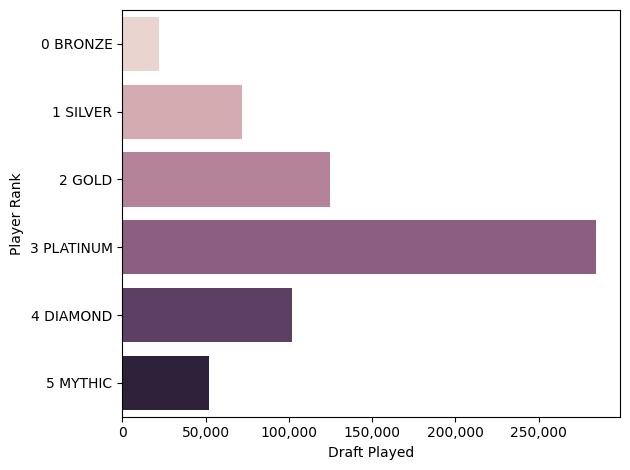

In [20]:
# | label: fig-rank-games
# | fig-cap: "Drafts Played by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="len", hue="rank_value", legend=False)
anno.set_labels_to_commas()
anno.set_axis_labels_and_show(xlabel="Draft Played", ylabel="Player Rank")

In @fig-ranks-win-rate, we observe that win rates vary by rank, with higher ranks generally achieving higher win rates. The Bronze rank has by far the lowest win rate, reflecting new or less skilled players. Interestingly, the Silver rank shows the highest win rate, likely due to the influx of Gold and Platinum players who reset to Silver at the start of the season and quickly climb back up the ranks.

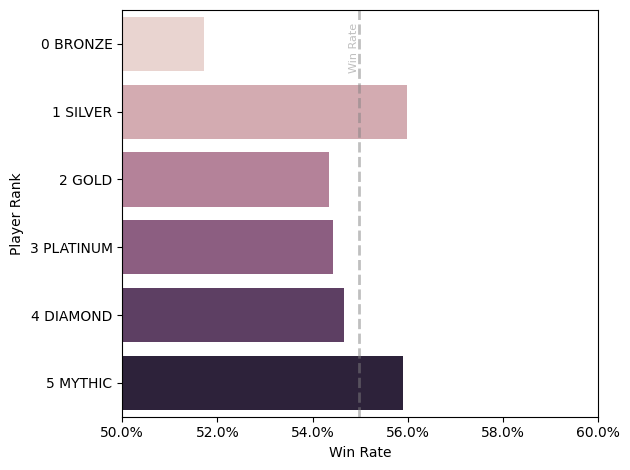

In [21]:
# | label: fig-ranks-win-rate
# | fig-cap: "Win Rate by Players of Different Ranks."

sns.barplot(data=ranks, y="rank_name", x="win_rate", hue="rank_value", legend=False)
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=-0.01)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(xlabel="Win Rate", ylabel="Player Rank")

For each rank, I plotted the win rate for the last week of play compared to the earlier timeframe. In @fig-ranked-win-rate-over-time, we see a decline in win rates for higher ranks but an increase in win rates for lower ranks. This pattern suggests that higher ranks may become more competitive as the season progresses, while lower ranks tend to become more casual.


In [22]:
max_date = df_draft.select(pl.col("draft_time").max()).collect().to_series()[0]

draft_rank = (
    df_draft.with_columns(
        (pl.col("draft_time") >= (max_date - pl.duration(days=6))).alias("last_week")
    )
    .group_by(["rank", "last_week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
    )
    .sort(by="n_wins", descending=True)
)


week_ranks = (
    ordered_ranks_df.join(draft_rank, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()

week_ranks["win_rate"] = week_ranks["n_wins"] / week_ranks["n_games"]

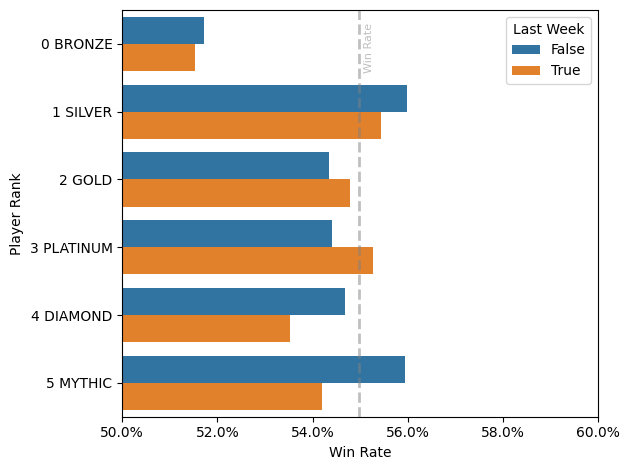

In [23]:
# | label: fig-ranked-win-rate-over-time
# | fig-cap: "Win Rate by Players of Different Ranks by Timeframe."

sns.barplot(data=week_ranks, y="rank_name", x="win_rate", hue="last_week")
plt.gca().set(xlim=(0.5, 0.60))

anno.plot_vert_line(x=mean_win_rate, label="Win Rate", y_pos=0.01, offset=0.02)
anno.set_labels_to_percent()
anno.set_axis_labels_and_show(
    xlabel="Win Rate",
    ylabel="Player Rank",
    legend=True,
    legend_title="Last Week",
)

@fig-ranked-n-games shows the number of games played per draft for each rank. While not identical, the pattern closely mirrors the previous chart of win rates.

In [24]:
ranks["games_per_draft"] = ranks["n_games"] / ranks["len"]
mean_games_played = df_draft.select(pl.col("n_games").mean()).collect().to_numpy()[0][0]

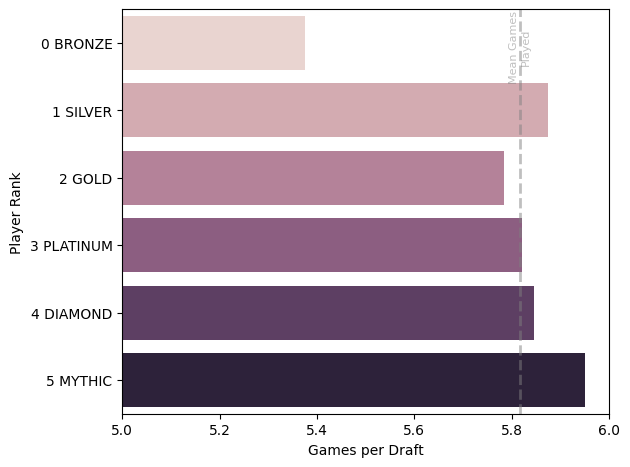

In [25]:
# | label: fig-ranked-n-games
# | fig-cap: "Games Played per Draft by Players of Different Ranks."

sns.barplot(
    data=ranks, y="rank_name", x="games_per_draft", hue="rank_value", legend=False
)
plt.gca().set(xlim=(5, 6))

anno.plot_vert_line(
    x=mean_games_played, label="Mean Games\nPlayed", y_pos=0.01, offset=0.0
)
anno.set_axis_labels_and_show(xlabel="Games per Draft", ylabel="Player Rank")

## Ranks over Time

We then examine the number of drafts played at each rank over time in @fig-ranked-drafts-over-time. Since the BLB set was released two days before the season start, I truncated the data at 08-01 to avoid the effects of rank decay.

The initial days are chaotic, with the BLB set launching on 07-30, and 07-31 being the first full day of recorded games. On 08-01, the new ranked season began, causing rank decay, which is especially noticeable in Mythic and Diamond gameplay.

Starting on 08-01, we observe distinct patterns: Gold rapidly declines after an initial peak of 3,800 drafts per day. Platinum peaks during days 4-6 before dropping. Diamond shows a slower climb with a plateau between days 8-13, followed by a gradual decline. Mythic starts at zero and slowly climbs, reaching a peak of 500 drafts per day around days 13-16.

From this chart, it's unclear how much of the decline at each rank is due to player advancement versus a loss of interest after the initial excitement of a new season. In the following charts, I will normalize the data to the total drafts played to better account for the overall decrease in gameplay.


In [26]:
rank_time_df = (
    df_draft.group_by(
        pl.col("draft_time").dt.truncate("1d")  # Truncate datetime to day
    )
    .agg(
        [
            pl.col("rank")
            .value_counts()
            .alias("rank_counts")  # Count occurrences of each rank
        ]
    )
    .explode("rank_counts")
    .with_columns(
        # Extract rank and count from the exploded struct
        pl.col("rank_counts").struct.field("rank").alias("rank"),
        pl.col("rank_counts").struct.field("count").alias("count"),
    )
    .drop("rank_counts")
    .join(ordered_ranks_df, on="rank", how="left")
    .sort(by=["draft_time", "rank_name"], descending=False)
    .collect()
    .to_pandas()
)

# trim partial first day
rank_time_df = rank_time_df.loc[
    rank_time_df["draft_time"] > rank_time_df["draft_time"].min()
]

first_days = rank_time_df["draft_time"][
    rank_time_df["draft_time"].dt.is_month_start
].drop_duplicates()

In [27]:
print(
    f"Total Time Interval: {(rank_time_df['draft_time'].max() - rank_time_df['draft_time'].min()).days} days"
)

Total Time Interval: 209 days


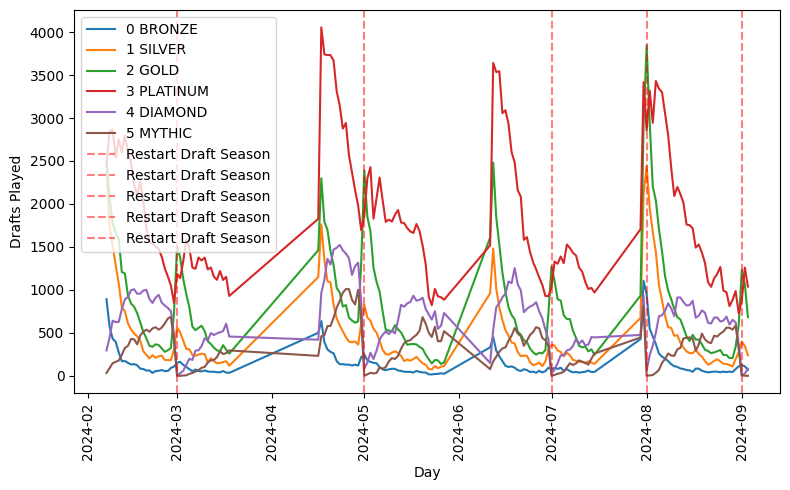

In [28]:
# | label: fig-ranked-drafts-over-time
# | fig-cap: "Drafts Played by Players Over Time, by Player rank."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df, x="draft_time", y="count", hue="rank_name")

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

In @fig-ranked-total-drafts-over-time, we see the number of drafts played over time. It's notable that the release of BLB and the start of the new season coincided, driving high player interest, with a peak of 11,300 drafts on 07-31. The rate of play decayed over the weeks, reaching a low of 3,100 on 08-17.

The decline is nearly monotonic, with slight increases on the Saturdays of 08-04 and 08-11, indicating that weekly seasonality has only a minor impact.

Releasing new sets clearly boosts player engagement. However, the introduction of the new season on 08-01 does not appear to have significantly increased play, though this observation is tentative. This data highlights the economic motivation for releasing new sets to drive digital engagement on Arena, and it’s likely that paper play would follow a similar trend, with increased draft activity consuming more booster packs in the weeks following a new set’s launch.

It would be valuable to compare this pattern across different set releases to better understand the player base’s set-by-set preferences.


In [29]:
rank_time_sum = (
    rank_time_df[["draft_time", "count"]].groupby(["draft_time"]).sum().reset_index()
)

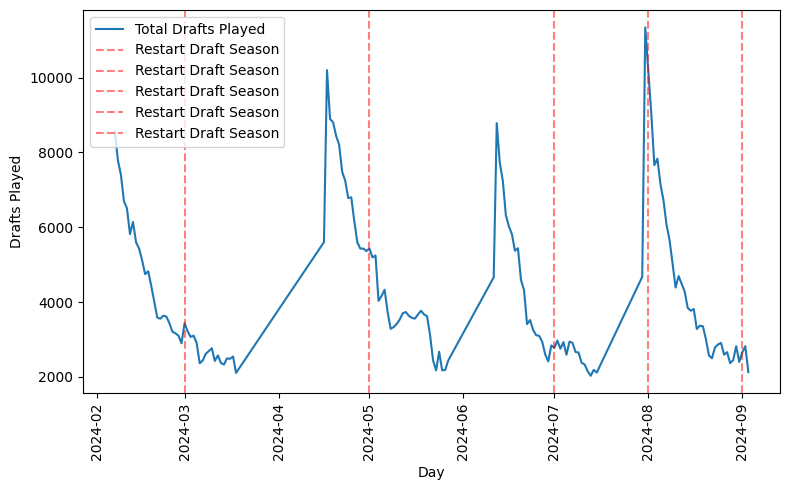

In [32]:
# | label: fig-ranked-total-drafts-over-time
# | fig-cap: "Total Drafts Played by Players Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_sum, x="draft_time", y="count", label="Total Drafts Played")

plt.xlim = (pd.to_datetime("2024-07-29"), rank_time_sum["draft_time"].max())
plt.ylim = (0, 12000)

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )


anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

Next, we normalize for the total games played to observe the relative ranked play across the player base, as shown in @fig-normalized-ranked-drafts-over-time.

This normalization highlights the relative activity at each rank more clearly. After the season starts, Gold exhibits a linear decay as players progress to Platinum. Platinum maintains a prolonged plateau, indicating a balance between new players entering the rank and existing players advancing.

Diamond and Mythic both start with minimal participation but gradually increase in play almost monotonically, albeit at different rates.

In [33]:
rank_time_df2 = rank_time_df.merge(
    rank_time_sum, on="draft_time", suffixes=("", "_sum")
)
rank_time_df2["rank_pct"] = rank_time_df2["count"] / rank_time_df2["count_sum"]

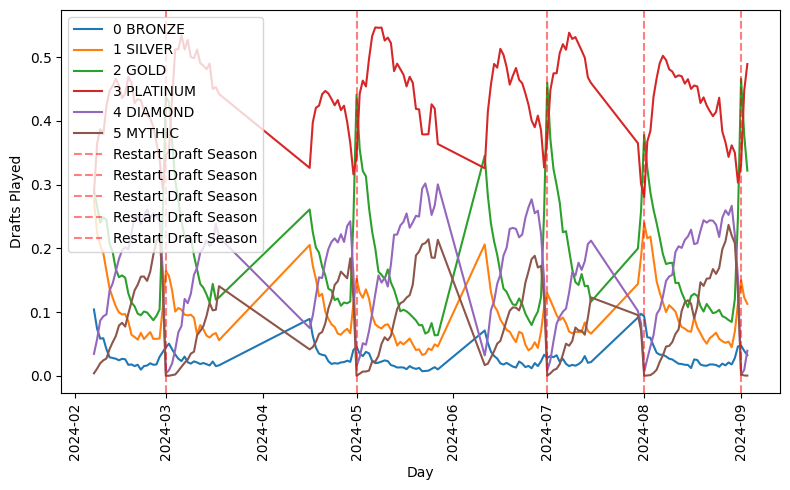

In [34]:
# | label: fig-normalized-ranked-drafts-over-time
# | fig-cap: "Normalized Drafts Played by Players of Different Ranks Over Time."

plt.figure(figsize=(8, 5))
sns.lineplot(data=rank_time_df2, x="draft_time", y="rank_pct", hue="rank_name")

for date in first_days:
    plt.axvline(
        x=date,
        color="red",
        linestyle="--",
        label="Restart Draft Season",
        alpha=0.5,
    )

anno.set_axis_labels_and_show(
    xlabel="Day", ylabel="Drafts Played", legend=True, rot_x=True
)

## Low vs High Rank Players

Now, let's compare player rank performance against success by focusing on the three two-color decks that were outliers in the previous use-rate versus win-rate chart.

| Deck | Use Rate | Win Rate      |
| ---- | -------- | ------------- |
| BG   | High     | High          |
| BR   | Low      | High          |
| UR   | Very Low | Extremely Low |

In @fig-top-decks-by-rank, we analyze the overall performance of players using these decks, categorized by the week of play and whether the player is in the elite ranks of Diamond or Mythic.

For BG, the most played deck, performance across weeks and ranks shows no clear trend. However, for the BR and UR decks, which are less frequently played, players in both elite ranks demonstrated noticeable improvements in win rates from week one to week two. This suggests that the 17Lands player base adapted and learned to optimize these less favorable decks, regardless of their rank.

It's important to note that during the first week of play, the Mythic and Diamond player base is relatively small.

In [35]:
draft_rank_deck = (
    df_draft.with_columns(
        (
            (
                (pl.col("draft_time") - pd.to_datetime("2024-07-30"))
                / pd.Timedelta(days=7)
            ).cast(pl.Int64)
        ).alias("week"),
        (pl.col("rank").is_in(["mythic", "diamond"])).alias("elite_ranks"),
    )
    .filter(
        pl.col("main_colors").is_in(["BG", "BR", "UR"]),
    )
    .group_by(["rank", "main_colors", "week"])
    .agg(
        pl.col("n_wins").len().alias("len"),
        pl.col("n_wins").sum(),
        pl.col("n_games").sum(),
        pl.col("elite_ranks").first(),
    )
    .sort(by="n_wins", descending=True)
)

ranks_deck = (
    ordered_ranks_df.join(draft_rank_deck, on="rank", how="left")
    .sort("rank_value")
    .collect()  # Execute the lazy frame
).to_pandas()
ranks_deck["win_rate"] = ranks_deck["n_wins"] / ranks_deck["n_games"]

ranks_deck = ranks_deck.rename(
    columns={
        "elite_ranks": "Rank of Mythic or Diamond",
        "week": "Week of Play",
        "main_colors": "Player Deck Colors",
        "win_rate": "Player Win Rate",
    }
)

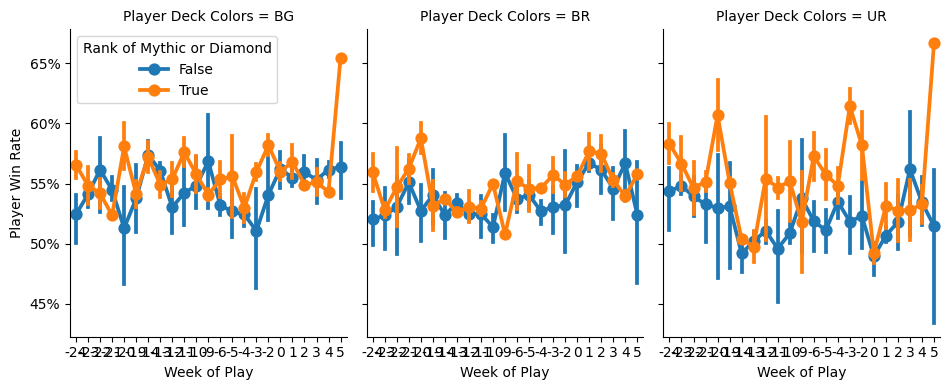

In [36]:
# | label: fig-top-decks-by-rank
# | fig-cap: "Win Rate for given color decks for top-ranked players vs others."

sns.catplot(
    data=ranks_deck,
    x="Week of Play",
    y="Player Win Rate",
    hue="Rank of Mythic or Diamond",
    kind="point",
    col="Player Deck Colors",
    height=4,
    aspect=0.8,
    legend_out=False,
)

anno.set_labels_to_percent(axis="y")
anno.set_axis_labels_and_show()